In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cellink.tl._burden_testing import *

In [17]:
cell_type_col = "cell_label"

In [4]:
base_data_dir = Path("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/")
input_dir = base_data_dir / "input_data"
## defining the path to the data
scdata_path = input_dir / "chr22_OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz"
gdata_path = input_dir / "plink/"
dump_path = base_data_dir / "output/example_output"
vep_anno_file = input_dir /  "all_variants_annotated_fixed_ref_reversed_id.txt"
DNA_LM_file = input_dir/ "onek1k_inf_scores_upstream_model.tsv"
## defining target chromosome
target_chromosome = "22"

In [19]:
gdata = ad.read_h5ad(input_dir / "gdata_chr22_with_annos.h5ad")
gdata.obs = gdata.obs.set_index("id", drop = False)

In [20]:
gdata.varm['annotations_0']

Location  gnomADe_OTH_AF  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_A_G  22:16849573             NaN                               1   
22_16849971_A_T  22:16849971             NaN                               1   
22_16850437_G_A  22:16850437             NaN                               1   
22_16851225_C_T  22:16851225             NaN                               1   
22_16851356_C_T  22:16851356             NaN                               1   
...                      ...             ...                             ...   
22_51202748_A_G  22:51202748             NaN                               0   
22_51208568_G_T  22:51208568             NaN                               0   
22_51211031_A_G  22:51211031             NaN                               0   
22_51213613_C_T  22:51213613             NaN                               0   
22_51216564_T_C  22:51216564             NaN                               0   

                 Consequence_start_lost  gnomADe_SAS_AF SOMATIC  CADD_PHRED  \
snp_id                                                                        
22_16849573_A_G                       0             NaN       -       8.747   
22_16849971_A_T                       0             NaN       -       8.843   
22_16850437_G_A                       0             NaN       -       8.063   
22_16851225_C_T                       0             NaN       -       8.324   
22_16851356_C_T                       0             NaN       -       8.148   
...                                 ...             ...     ...         ...   
22_51202748_A_G                       0             NaN       -       9.870   
22_51208568_G_T                       0             NaN       -       4.299   
22_51211031_A_G                       0             NaN       -       5.127   
22_51213613_C_T                       0             NaN       -       0.190   
22_51216564_T_C                       0             NaN       -       1.282   

                CLIN_SIG  gnomADe_EAS_AF Feature_type  ...  \
snp_id                                                 ...   
22_16849573_A_G        -             NaN            -  ...   
22_16849971_A_T        -             NaN            -  ...   
22_16850437_G_A        -             NaN            -  ...   
22_16851225_C_T        -             NaN            -  ...   
22_16851356_C_T        -             NaN            -  ...   
...                  ...             ...          ...  ...   
22_51202748_A_G        -             NaN   Transcript  ...   
22_51208568_G_T        -             NaN   Transcript  ...   
22_51211031_A_G        -             NaN   Transcript  ...   
22_51213613_C_T        -             NaN   Transcript  ...   
22_51216564_T_C        -             NaN   Transcript  ...   

                 Consequence_splice_acceptor_variant  \
snp_id                                                 
22_16849573_A_G                                    0   
22_16849971_A_T                                    0   
22_16850437_G_A                                    0   
22_16851225_C_T                                    0   
22_16851356_C_T                                    0   
...                                              ...   
22_51202748_A_G                                    0   
22_51208568_G_T                                    0   
22_51211031_A_G                                    0   
22_51213613_C_T                                    0   
22_51216564_T_C                                    0   

                Consequence_splice_donor_5th_base_variant  \
snp_id                                                      
22_16849573_A_G                                         0   
22_16849971_A_T                                         0   
22_16850437_G_A                                         0   
22_16851225_C_T                                         0   
22_16851356_C_T                                  

In [21]:
scdata = sc.read_h5ad(scdata_path)
scdata.var["chrom"] = "22" #current fix before chromosome is added to object 
scdata

AnnData object with n_obs × n_vars = 1272489 × 673
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features', 'chrom'

In [22]:
scdata.obs[cell_type_col].unique()

['CD4 ET', 'NK', 'CD4 NC', 'CD8 S100B', 'CD8 ET', ..., 'Mono C', 'Platelets', 'DC', 'Plasma', 'CD4 SOX4']
Length: 16
Categories (16, object): ['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', ..., 'NK', 'NK R', 'Plasma', 'Platelets']

In [23]:
data = cl.DonorData(adata=scdata, gdata=gdata, donor_key_in_sc_adata="individual")

[2024-12-16 16:43:01,985] INFO:cellink._core.donordata: Keeping 981/1034 donors
[2024-12-16 16:43:01,986] INFO:cellink._core.donordata: Dropping 53/1034 donors from genetic data
[2024-12-16 16:43:01,986] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


### compute gene burdens

In [24]:
gdata = ad.read_h5ad(input_dir / "gdata_chr22_with_annos.h5ad")
gdata.obs = gdata.obs.set_index("id", drop = False)

In [25]:
gdata

AnnData object with n_obs × n_vars = 1034 × 143083
    obs: 'id'
    var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2', 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'
    varm: 'annotations_0', 'annotations_1', 'annotations_2', 'annotations_3', 'annotations_4', 'annotations_5', 'annotations_6', 'annotations_7'

In [26]:
plink_file = os.path.join(gdata_path, f"chr{target_chromosome}.dose.filtered.R2_0.8")
gdata = cl.io.read_plink(plink_file)

In [27]:
gdata

AnnData object with n_obs × n_vars = 1034 × 96257
    obs: 'family_id', 'member_id', 'paternal_id', 'maternal_id', 'sex', 'phenotype'
    var: 'chrom', 'pos', 'a0', 'a1', 'contig', 'id', 'maf'

In [28]:
# add annotations to gdata 
cl.tl.add_vep_annos_to_gdata(vep_anno_file, gdata,
                             cols_to_explode=["Consequence"],
                             cols_to_dummy=["Consequence"])
gdata

/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_annotate_snps_genotype_data.py:293: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  annos = pd.read_csv(


[2024-12-16 16:43:48,937] INFO:cellink.tl._annotate_snps_genotype_data: renaming id column #Uploaded_variation into snp_id
[2024-12-16 16:43:54,814] INFO:cellink.tl._annotate_snps_genotype_data: Subsetting annotations to variants that are in gdata
[2024-12-16 16:44:02,648] INFO:cellink.tl._annotate_snps_genotype_data: Index(['snp_id', 'Location', 'Allele', 'Gene', 'Feature', 'Feature_type',
       'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE',
       'STRAND', 'FLAGS', 'BIOTYPE', 'CANONICAL', 'ENSP', 'SIFT', 'PolyPhen',
       'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF', 'gnomADe_ASJ_AF',
       'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_NFE_AF', 'gnomADe_OTH_AF',
       'gnomADe_SAS_AF', 'CLIN_SIG', 'SOMATIC', 'PHENO', 'CADD_PHRED',
       'CADD_RAW', 'TSSDistance'],
      dtype='object')
[2024-12-16 16:44:02,863] INFO:cellink.tl.utils: Exploding column Consequence
[2024-12-16 16:44

KeyboardInterrupt: 

In [12]:
from cellink.tl.utils import (
    _explode_columns,
    _get_vep_start_row,
    _add_dummy_cols,
    _flatten_single_value,
)
pd.read_csv(
        vep_anno_file, sep="\t", skiprows=_get_vep_start_row(vep_anno_file)
    )

/scratch/tmp/l_back/ipykernel_2639080/1924758431.py:7: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


#Uploaded_variation     Location Allele             Gene  \
0              1_715265_T/C     1:715265      T  ENSG00000237491   
1              1_715265_T/C     1:715265      T  ENSG00000228327   
2              1_715367_G/A     1:715367      G  ENSG00000228327   
3              1_715367_G/A     1:715367      G  ENSG00000237491   
4              1_717485_A/C     1:717485      A  ENSG00000228327   
...                     ...          ...    ...              ...   
8579248     22_51211031_G/A  22:51211031      G  ENSG00000079974   
8579249     22_51213613_T/C  22:51213613      T  ENSG00000184319   
8579250     22_51213613_T/C  22:51213613      T  ENSG00000079974   
8579251     22_51216564_C/T  22:51216564      C  ENSG00000184319   
8579252     22_51216564_C/T  22:51216564      C  ENSG00000079974   

                 Feature Feature_type  \
0        ENST00000434264   Transcript   
1        ENST00000428504   Transcript   
2        ENST00000428504   Transcript   
3        ENST00000434264   Transcript   
4        ENST00000428504   Transcript   
...                  ...          ...   
8579248  ENST00000395593   Transcript   
8579249  ENST00000496652   Transcript   
8579250  ENST00000395593   Transcript   
8579251  ENST00000496652   Transcript   
8579252  ENST00000395593   Transcript   

                                          Consequence cDNA_position  \
0        intron_variant,non_coding_transcript_variant             -   
1                               upstream_gene_variant             -   
2                               upstream_gene_variant             -   
3        intron_variant,non_coding_transcript_variant             -   
4                               upstream_gene_variant             -   
...                                               ...           ...   
8579248                                intron_variant             -   
8579249  intron_variant,non_coding_transcript_variant             -   
8579250                                intron_variant             -   
8579251  intron_variant,non_coding_transcript_variant             -   
8579252                                intron_variant             -   

        CDS_position Protein_position  ... gnomADe_FIN_AF gnomADe_NFE_AF  \
0                  -                -  ...              -              -   
1                  -                -  ...              -              -   
2                  -                -  ...              -              -   
3                  -                -  ...              -              -   
4                  -                -  ...              -              -   
...              ...              ...  ...            ...            ...   
8579248            -                -  ...              -              -   
8579249            -                -  ...              -              -   
8579250            -                -  ...              -              -   
8579251            -                -  ...              -              -   
8579252            -                -  ...              -              -   

        gnomADe_OTH_AF gnomADe_SAS_AF CLIN_SIG SOMATIC PHENO CADD_PHRED  \
0                    -              -        -       -     -      1.266   
1                    -              -        -       -     -      1.266   
2                    -              -        -       -     -      2.493   
3                    -              -        -       -     -      2.493   
4                    -              -        -       -     -      0.400   
...                ...            ...      ...     ...   ...        ...   
8579248              -              -        -       -     -      5.127   
8579249              -              -        -       -     -      0.190   
8579250              -              -        -       -     -      0.190   
8579251              -              -        -       -     -      1.282   
8579252              -              -        -       -     -      1.282   

         CADD_RAW TSSDistance  

In [33]:
pd.read_csv(DNA_LM_file,
            sep = '\t')

Chromosome     Start       End Strand       pos ref alt  \
0             chr1    714263    716266      +    715265   C   T   
1             chr1    714365    716368      +    715367   A   G   
2             chr1    716483    718486      +    717485   C   A   
3             chr1    719379    721382      +    720381   G   T   
4             chr1    720288    722291      +    721290   G   C   
...            ...       ...       ...    ...       ...  ..  ..   
7406078      chr22  51201746  51203749      +  51202748   A   G   
7406079      chr22  51207566  51209569      +  51208568   G   T   
7406080      chr22  51210029  51212032      +  51211031   A   G   
7406081      chr22  51212611  51214614      +  51213613   C   T   
7406082      chr22  51215562  51217565      +  51216564   T   C   

         index_w_table    index  influence_score  
0                    0        0         0.013309  
1                    1        1         0.020517  
2                    2        2         0.027624  
3                    3        3         0.026201  
4                    4        4         0.022432  
...                ...      ...              ...  
7406078          96252  7406078         0.033990  
7406079          96253  7406079         0.031510  
7406080          96254  7406080         0.024377  
7406081          96255  7406081         0.024270  
7406082          96256  7406082         0.020555  

[7406083 rows x 10 columns]

In [ ]:
# create donor data 
data = cl.DonorData(adata=scdata, gdata=gdata, donor_key_in_sc_adata="individual")

In [28]:
gdata.varm["annotations_0"].columns

Index(['gnomADe_EAS_AF', 'Feature_type', 'Consequence_intergenic_variant',
       'PHENO', 'Consequence_start_lost', 'gnomADe_AMR_AF',
       'Existing_variation', 'CLIN_SIG', 'CADD_RAW', 'gnomADe_NFE_AF',
       'CADD_PHRED', 'gnomADe_ASJ_AF', 'gnomADe_OTH_AF', 'Allele', 'SOMATIC',
       'Location', 'gnomADe_SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF',
       'gnomADe_FIN_AF', 'Gene', 'Feature', 'cDNA_position', 'CDS_position',
       'Protein_position', 'Amino_acids', 'Codons', 'IMPACT', 'DISTANCE',
       'STRAND', 'FLAGS', 'BIOTYPE', 'CANONICAL', 'ENSP', 'SIFT', 'PolyPhen',
       'TSSDistance', 'Consequence_3_prime_UTR_variant',
       'Consequence_5_prime_UTR_variant', 'Consequence_NMD_transcript_variant',
       'Consequence_coding_sequence_variant',
       'Consequence_downstream_gene_variant',
       'Consequence_incomplete_terminal_codon_variant',
       'Consequence_intron_variant', 'Consequence_mature_miRNA_variant',
       'Consequence_missense_variant',
       'Consequence_n

In [39]:
gdata.varm["annotations_0"]["DISTANCE"][~gdata.varm["annotations_0"]["DISTANCE"].isna()]

snp_id
22_16872281_C_G     668.0
22_16873251_A_C    1638.0
22_16873461_A_G    1848.0
22_16881807_A_C    4249.0
22_16885946_G_C     110.0
                    ...  
22_51195550_A_C    1689.0
22_51196164_T_A    2303.0
22_51196296_C_G    2435.0
22_51197602_A_T    3741.0
22_51198569_C_G    4708.0
Name: DISTANCE, Length: 18900, dtype: float64

In [40]:
all_burdens = compute_burdens(data, max_af=0.05, weight_cols=["DISTANCE", "CADD_PHRED"])
all_burdens.to_parquet("all_burdens_chr22.parquet")



00%|██████████| 673/673 [21:29<00:00,  1.92s/it]

In [43]:
type(data)

cellink._core.donordata.DonorData

In [6]:
import pickle

In [45]:
with open("data.pkl", "wb") as file:
    pickle.dump(data, file)

In [7]:
with open("data.pkl", "rb") as file:
    data = pickle.load(file)

In [14]:
data.gdata.varm["annotations_0"]

gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_non_coding_transcript_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_C                                          0   
...                                                    ...   
22_51202748_G_A                                          0   
22_51208568_T_G                                          0   
22_51211031_G_A                                          0   
22_51213613_T_C                                          0   
22_51216564_C_T                                          0   

                 Consequence_splice_acceptor_variant  \
snp_id                                                 
22_16849573_G_A                                    0   
22_16849971_T_A                                    0   
22_16850437_A_G                                    0   
22_16851225_T_C             

### ADD DNA_LM to annotations_0

In [16]:
DNA_LM = pd.read_csv(DNA_LM_file,
            sep = '\t')
DNA_LM

# add id_col : chr1> 1 + _ + pos + _ + ref + _ + alt

# Combine 'Chromosome', 'pos', 'ref', and 'alt' into the 'snap_id'
DNA_LM['snp_id'] = DNA_LM['Chromosome'] + "_" + DNA_LM['pos'].astype(str) + "_" + DNA_LM['ref'] + "_" + DNA_LM['alt']
DNA_LM['snp_id'] = DNA_LM['snp_id'].str.replace('chr', '')

# Set 'snap_id' as the index
DNA_LM.set_index('snp_id', inplace=True)


Chromosome     Start       End Strand       pos ref alt  \
snp_id                                                                    
1_715265_C_T          chr1    714263    716266      +    715265   C   T   
1_715367_A_G          chr1    714365    716368      +    715367   A   G   
1_717485_C_A          chr1    716483    718486      +    717485   C   A   
1_720381_G_T          chr1    719379    721382      +    720381   G   T   
1_721290_G_C          chr1    720288    722291      +    721290   G   C   
...                    ...       ...       ...    ...       ...  ..  ..   
22_51202748_A_G      chr22  51201746  51203749      +  51202748   A   G   
22_51208568_G_T      chr22  51207566  51209569      +  51208568   G   T   
22_51211031_A_G      chr22  51210029  51212032      +  51211031   A   G   
22_51213613_C_T      chr22  51212611  51214614      +  51213613   C   T   
22_51216564_T_C      chr22  51215562  51217565      +  51216564   T   C   

                 index_w_table    index  influence_score  
snp_id                                                    
1_715265_C_T                 0        0         0.013309  
1_715367_A_G                 1        1         0.020517  
1_717485_C_A                 2        2         0.027624  
1_720381_G_T                 3        3         0.026201  
1_721290_G_C                 4        4         0.022432  
...                        ...      ...              ...  
22_51202748_A_G          96252  7406078         0.033990  
22_51208568_G_T          96253  7406079         0.031510  
22_51211031_A_G          96254  7406080         0.024377  
22_51213613_C_T          96255  7406081         0.024270  
22_51216564_T_C          96256  7406082         0.020555  

[7406083 rows x 10 columns]

In [17]:
DNA_LM[DNA_LM["Chromosome"]=="chr22"]

Chromosome     Start       End Strand       pos ref alt  \
snp_id                                                                    
22_16849573_A_G      chr22  16848571  16850574      +  16849573   A   G   
22_16849971_A_T      chr22  16848969  16850972      +  16849971   A   T   
22_16850437_G_A      chr22  16849435  16851438      +  16850437   G   A   
22_16851225_C_T      chr22  16850223  16852226      +  16851225   C   T   
22_16851356_C_T      chr22  16850354  16852357      +  16851356   C   T   
...                    ...       ...       ...    ...       ...  ..  ..   
22_51202748_A_G      chr22  51201746  51203749      +  51202748   A   G   
22_51208568_G_T      chr22  51207566  51209569      +  51208568   G   T   
22_51211031_A_G      chr22  51210029  51212032      +  51211031   A   G   
22_51213613_C_T      chr22  51212611  51214614      +  51213613   C   T   
22_51216564_T_C      chr22  51215562  51217565      +  51216564   T   C   

                 index_w_table    index  influence_score  
snp_id                                                    
22_16849573_A_G              0  7309826         0.053059  
22_16849971_A_T              1  7309827         0.076044  
22_16850437_G_A              2  7309828         0.054154  
22_16851225_C_T              3  7309829         0.109348  
22_16851356_C_T              4  7309830         0.116335  
...                        ...      ...              ...  
22_51202748_A_G          96252  7406078         0.033990  
22_51208568_G_T          96253  7406079         0.031510  
22_51211031_A_G          96254  7406080         0.024377  
22_51213613_C_T          96255  7406081         0.024270  
22_51216564_T_C          96256  7406082         0.020555  

[96257 rows x 10 columns]

In [22]:
# Function to reverse ref/alt in DNA_LM where the reverse matches in data_gdata_varm
def reverse_and_update_snp_ids(gdata_df, dna_df):
    updated_index = []
    
    for snp_id in dna_df.index:
        if snp_id in gdata_df.index:
            updated_index.append(snp_id)
        else:
            chrom, pos, ref, alt = snp_id.split("_")
            reversed_snp_id = f"{chrom}_{pos}_{alt}_{ref}"  # Reverse ref and alt
            
            # Check if reversed_snp_id exists in data_df
            if reversed_snp_id in gdata_df.index:
                #print(f"Reversing {snp_id} to {reversed_snp_id}")
                updated_index.append(reversed_snp_id)
            else:
                print(f"Error, unknown snp_id {snp_id}")
                updated_index.append(snp_id)

            
    
    # Update DNA_LM's index
    dna_df.index = updated_index
    print("\nUpdated DNA_LM index:")
    print(dna_df.index)
    return dna_df

# Run the function
DNA_LM_chr22 = reverse_and_update_snp_ids(data.gdata.varm["annotations_0"], DNA_LM[DNA_LM["Chromosome"]=="chr22"])


Updated DNA_LM index:
Index(['22_16849573_G_A', '22_16849971_T_A', '22_16850437_A_G',
       '22_16851225_T_C', '22_16851356_T_C', '22_16851640_T_C',
       '22_16851673_G_A', '22_16851899_G_C', '22_16852312_A_G',
       '22_16852652_A_G',
       ...
       '22_51197602_A_T', '22_51198569_C_G', '22_51198868_C_T',
       '22_51198906_A_G', '22_51198998_A_C', '22_51202748_G_A',
       '22_51208568_T_G', '22_51211031_G_A', '22_51213613_T_C',
       '22_51216564_C_T'],
      dtype='object', length=96257)


In [40]:
def add_DNA_LM():
    pass

In [33]:
all_burdens = pd.read_parquet("all_burdens_chr22.parquet")

In [39]:
data.gdata.varm["annotations_0"]["DNA_LM_influence_score"] = DNA_LM_chr22["influence_score"]
data.gdata.varm["annotations_0"]

gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_splice_acceptor_variant  \
snp_id                                                 
22_16849573_G_A                                    0   
22_16849971_T_A                                    0   
22_16850437_A_G                                    0   
22_16851225_T_C                                    0   
22_16851356_T_C                                    0   
...                                              ...   
22_51202748_G_A                                    0   
22_51208568_T_G                                    0   
22_51211031_G_A                                    0   
22_51213613_T_C                                    0   
22_51216564_C_T                                    0   

                 Consequence_splice_donor_5th_base_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_

### run association testing

In [41]:
precomputed_burdens = pd.read_parquet(input_dir/ "all_burdens_chr22.parquet")

In [17]:
# target_genes = precomputed_burdens["Geneid"].unique()[:10]
# target_genes

In [ ]:
target_cell_type = "CD4 ET"

burden_test(
            donor_data = data,
            gene_burdens = all_burdens,
            target_cell_type = target_cell_type,
            target_chromosome = target_chromosome,
            dump_dir = dump_path,
            # target_genes = target_genes,
            transforms_seq = None #TODO comment this back in to quantile transform phenotype. Commented out to make testing faster
)

#  From here on old code!!! 

#### Association testing for all cell types 

In [30]:
cell_types = data.adata.obs[cell_type_col].unique()
cell_types

['CD8 ET', 'CD8 NC', 'CD4 NC', 'Mono C', 'NK', ..., 'DC', 'NK R', 'Platelets', 'CD4 SOX4', 'Erythrocytes']
Length: 16
Categories (16, object): ['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', ..., 'NK', 'NK R', 'Plasma', 'Platelets']

In [34]:
all_res = []
#cell_types = ["CD4 NC", "B IN", "B Mem"]
for target_cell_type in cell_types:
    print(target_cell_type)
    this_res = burden_test(
            donor_data = data,
            gene_burdens = all_burdens,
            target_cell_type = target_cell_type,
            target_chromosome = target_chromosome,
            dump_dir = dump_path,
            # target_genes = target_genes,
            transforms_seq = None #TODO comment this back in to quantile transform phenotype. Commented out to make testing faster
            )
    all_res.append(this_res[0])
all_res = pd.concat(all_res)


CD8 ET


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:49:07,512] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:49:07,513] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:49:07,515] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:49:07,548] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:49:07,553] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 478 genes for current combination of target_cell_type='CD8 ET', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:49:33,106] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
CD8 NC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:49:35,988] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:49:35,995] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:49:35,996] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:49:36,048] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:49:36,064] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 468 genes for current combination of target_cell_type='CD8 NC', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid valu

[2024-12-16 16:50:00,617] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
CD4 NC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:50:09,218] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:50:09,219] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:50:09,219] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:50:09,258] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:50:09,263] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 504 genes for current combination of target_cell_type='CD4 NC', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:50:37,930] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


Mono C


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:50:39,341] INFO:cellink._core.donordata: Keeping 968/981 donors
[2024-12-16 16:50:39,342] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2024-12-16 16:50:39,342] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data
[2024-12-16 16:50:39,371] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:50:39,376] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 420 genes for current combination of target_cell_type='Mono C', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:51:00,794] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
NK


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])


[2024-12-16 16:51:03,733] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:51:03,734] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:51:03,734] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:51:03,764] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:51:03,769] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 478 genes for current combination of target_cell_type='NK', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed

[2024-12-16 16:51:30,080] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


B IN


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:51:31,777] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:51:31,778] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:51:31,779] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:51:31,808] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:51:31,813] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 450 genes for current combination of target_cell_type='B IN', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid valu

[2024-12-16 16:51:56,112] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
CD4 ET


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:51:57,676] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:51:57,677] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:51:57,677] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:51:57,707] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:51:57,713] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 435 genes for current combination of target_cell_type='CD4 ET', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid valu

[2024-12-16 16:52:20,269] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


Mono NC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:52:20,987] INFO:cellink._core.donordata: Keeping 933/981 donors
[2024-12-16 16:52:20,988] INFO:cellink._core.donordata: Dropping 48/981 donors from genetic data
[2024-12-16 16:52:20,988] INFO:cellink._core.donordata: Dropping 0/933 donors from single-cell data
[2024-12-16 16:52:21,017] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:52:21,022] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 367 genes for current combination of target_cell_type='Mono NC', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:52:38,204] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


CD8 S100B


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:52:39,246] INFO:cellink._core.donordata: Keeping 980/981 donors
[2024-12-16 16:52:39,247] INFO:cellink._core.donordata: Dropping 1/981 donors from genetic data
[2024-12-16 16:52:39,247] INFO:cellink._core.donordata: Dropping 0/980 donors from single-cell data
[2024-12-16 16:52:39,277] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:52:39,283] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 406 genes for current combination of target_cell_type='CD8 S100B', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid valu

[2024-12-16 16:52:59,105] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


B Mem


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:53:00,258] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-16 16:53:00,259] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-16 16:53:00,260] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-16 16:53:00,289] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:53:00,294] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 421 genes for current combination of target_cell_type='B Mem', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:53:20,854] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


Plasma


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:53:21,367] INFO:cellink._core.donordata: Keeping 795/981 donors
[2024-12-16 16:53:21,368] INFO:cellink._core.donordata: Dropping 186/981 donors from genetic data
[2024-12-16 16:53:21,368] INFO:cellink._core.donordata: Dropping 0/795 donors from single-cell data
[2024-12-16 16:53:21,397] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:53:21,403] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 346 genes for current combination of target_cell_type='Plasma', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:53:34,848] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


DC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:53:35,352] INFO:cellink._core.donordata: Keeping 968/981 donors
[2024-12-16 16:53:35,353] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2024-12-16 16:53:35,354] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data
[2024-12-16 16:53:35,381] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:53:35,387] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 394 genes for current combination of target_cell_type='DC', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:53:50,701] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
NK R
[2024-12-16 16:53:51,126] INFO:cellink._core.donordata: Keeping 969/981 donors
[2024-12-16 16:53:51,126] INFO:cellink._core.donordata: Dropping 12/981 donors from genetic data
[2024-12-16 16:53:51,127] INFO:cellink._core.donordata: Dropping 0/969 donors from single-cell data
[2024-12-16 16:53:51,160] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:53:51,165] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 350 genes for current combination of target_cell_type='NK R', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_ke

[2024-12-16 16:54:04,166] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'



/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_k

Platelets
[2024-12-16 16:54:04,470] INFO:cellink._core.donordata: Keeping 765/981 donors
[2024-12-16 16:54:04,471] INFO:cellink._core.donordata: Dropping 216/981 donors from genetic data
[2024-12-16 16:54:04,471] INFO:cellink._core.donordata: Dropping 0/765 donors from single-cell data


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


[2024-12-16 16:54:04,499] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:54:04,504] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 324 genes for current combination of target_cell_type='Platelets', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:54:19,012] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])


CD4 SOX4
[2024-12-16 16:54:19,386] INFO:cellink._core.donordata: Keeping 857/981 donors
[2024-12-16 16:54:19,387] INFO:cellink._core.donordata: Dropping 124/981 donors from genetic data
[2024-12-16 16:54:19,387] INFO:cellink._core.donordata: Dropping 0/857 donors from single-cell data
[2024-12-16 16:54:19,416] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:54:19,420] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 296 genes for current combination of target_cell_type='CD4 SOX4', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed

[2024-12-16 16:54:31,487] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'



/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_key_in_scdata).agg(["unique"])
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reference_data = reference_data.groupby(donor_k

Erythrocytes
[2024-12-16 16:54:31,627] INFO:cellink._core.donordata: Keeping 219/981 donors
[2024-12-16 16:54:31,627] INFO:cellink._core.donordata: Dropping 762/981 donors from genetic data
[2024-12-16 16:54:31,628] INFO:cellink._core.donordata: Dropping 0/219 donors from single-cell data
[2024-12-16 16:54:31,655] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-16 16:54:31,659] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 182 genes for current combination of target_cell_type='Erythrocytes', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
  pb_data.adata.layers["transformed_mean"] = Y
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  pb_data.gdata.uns["gene_burdens"] = gene_burdens.query("Geneid in @target_genes")
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
  return (X - X.mean(0)) / (X.std(0) * np.sqrt(X.shape[1]))
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning:

[2024-12-16 16:54:37,689] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


#### Evaluate results 

In [35]:
all_res["pvalue_corrected"] = all_res["pvalue"] * len(all_res)
all_res["significant"] = all_res["pvalue_corrected"] < 0.05

In [36]:
all_res.query("significant & burden_type== 'DISTANCE'")

burden_gene      target_gene burden_type        pvalue      beta  \
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.916588e-08 -0.016715   
0  ENSG00000075234  ENSG00000075234    DISTANCE  9.403489e-07 -0.014183   
0  ENSG00000100376  ENSG00000100376    DISTANCE  6.866745e-09 -0.029376   
0  ENSG00000212939  ENSG00000212939    DISTANCE  5.519238e-09 -0.003584   
0  ENSG00000212939  ENSG00000212939    DISTANCE  8.346789e-09 -0.001639   
0  ENSG00000167074  ENSG00000167074    DISTANCE  9.215874e-07 -0.004201   
0  ENSG00000128408  ENSG00000128408    DISTANCE  1.625602e-06 -0.001518   
0  ENSG00000075234  ENSG00000075234    DISTANCE  1.033692e-35 -0.082836   
0  ENSG00000212939  ENSG00000212939    DISTANCE  3.726373e-09 -0.004197   
0  ENSG00000100376  ENSG00000100376    DISTANCE  2.761008e-08 -0.064352   
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.294242e-07 -0.026966   
0  ENSG00000188130  ENSG00000188130    DISTANCE  9.181542e-07 -0.001338   
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.173660e-08 -0.021439   
0  ENSG00000100376  ENSG00000100376    DISTANCE  7.277932e-07 -0.082564   
0  ENSG00000099968  ENSG00000099968    DISTANCE  8.560039e-07 -0.112461   

      cell_type chrom  pvalue_corrected  significant  
0        CD8 ET    22      2.422184e-04         True  
0        CD8 ET    22      1.188413e-02         True  
0        CD8 NC    22      8.678193e-05         True  
0        CD8 NC    22      6.975213e-05         True  
0        CD4 NC    22      1.054867e-04         True  
0        Mono C    22      1.164702e-02         True  
0        Mono C    22      2.054436e-02         True  
0            NK    22      1.306380e-31         True  
0            NK    22      4.709390e-05         True  
0       Mono NC    22      3.489362e-04         True  
0     CD8 S100B    22      1.635663e-03         True  
0     CD8 S100B    22      1.160363e-02         True  
0         B Mem    22      1.483272e-04         True  
0            DC    22      9.197850e-03         True  
0  Erythrocytes    22      1.081818e-02         True

In [39]:
e_genes_per_cell_type = all_res\
    .groupby(["cell_type", "burden_type"])["significant"].sum()\
    .to_frame(name = "count").reset_index()
e_genes_per_cell_type

cell_type burden_type  count
0           B IN  CADD_PHRED      1
1           B IN    DISTANCE      0
2          B Mem  CADD_PHRED      2
3          B Mem    DISTANCE      1
4         CD4 ET  CADD_PHRED      1
5         CD4 ET    DISTANCE      0
6         CD4 NC  CADD_PHRED      3
7         CD4 NC    DISTANCE      1
8       CD4 SOX4  CADD_PHRED      1
9       CD4 SOX4    DISTANCE      0
10        CD8 ET  CADD_PHRED      4
11        CD8 ET    DISTANCE      2
12        CD8 NC  CADD_PHRED      3
13        CD8 NC    DISTANCE      2
14     CD8 S100B  CADD_PHRED      1
15     CD8 S100B    DISTANCE      2
16            DC  CADD_PHRED      1
17            DC    DISTANCE      1
18  Erythrocytes  CADD_PHRED      0
19  Erythrocytes    DISTANCE      1
20        Mono C  CADD_PHRED      1
21        Mono C    DISTANCE      2
22       Mono NC  CADD_PHRED      1
23       Mono NC    DISTANCE      1
24            NK  CADD_PHRED      4
25            NK    DISTANCE      2
26          NK R  CADD_PHRED      0
27          NK R    DISTANCE      0
28        Plasma  CADD_PHRED      2
29        Plasma    DISTANCE      0
30     Platelets  CADD_PHRED      1
31     Platelets    DISTANCE      0

In [49]:
with open("all_res.pkl", "wb") as file:
    pickle.dump(all_res, file)

In [40]:
zero_types = list(e_genes_per_cell_type.groupby("cell_type").sum().query("count ==0").index)

[2024-12-16 16:56:45,870] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


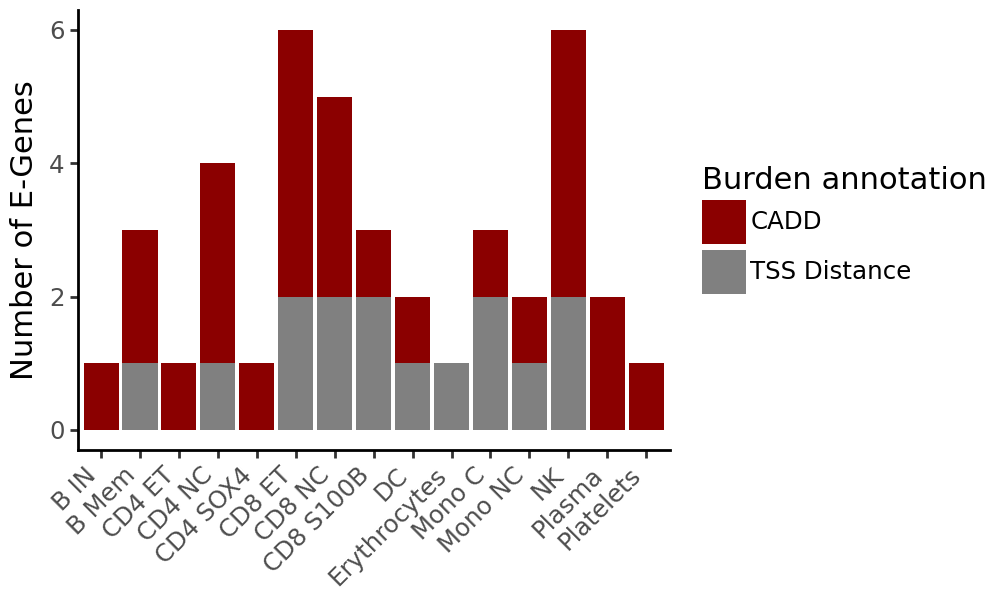

In [43]:
from plotnine import *
plot = (
    ggplot(e_genes_per_cell_type.query("cell_type not in @zero_types"), 
           aes(x='cell_type', y='count'))  # Specify the x and y variables
    + geom_bar(aes(fill = "burden_type"), stat = "identity")  # Add the boxplot layer
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (5,3)) 
            #legend_position="none")
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")
    + scale_fill_manual(values = ['darkred', "grey"], labels = ["CADD",  "TSS Distance"])
)
plot

[2024-12-16 16:56:55,937] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


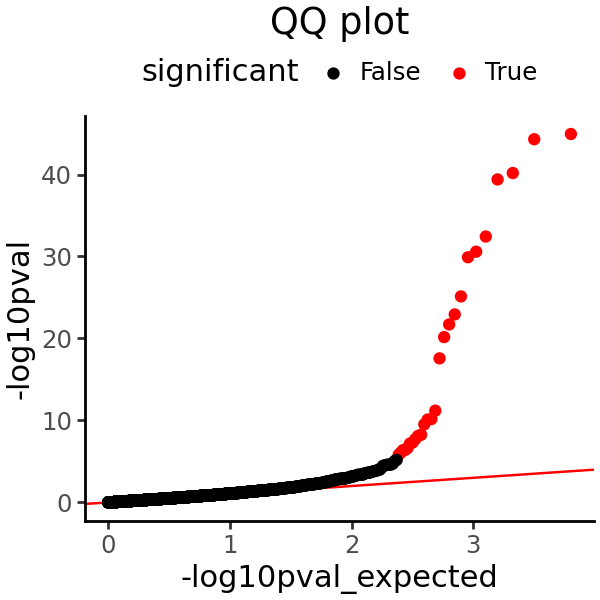

In [44]:
df = all_res.copy().query("burden_type == 'CADD_PHRED'")

df = df.sort_values("pvalue")
df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))

if "-log10pval" not in df.columns:
    df["-log10pval"] = -np.log10(df["pvalue"])

aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
plot = (
    ggplot(df, aes(**aes_kwargs, color="significant"))
    + labs(title="QQ plot")
    + scale_color_manual(values = ["black", "red"])
    + theme_classic()
    + geom_abline(intercept=0, slope=1, color="red")
    + geom_point()
    + theme(legend_position="top", figure_size = (3,3))
)
plot

In [46]:
data.adata.obs.groupby(cell_type_col).size().sort_values()

/scratch/tmp/l_back/ipykernel_2639080/914701118.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


cell_label
Erythrocytes       680
Plasma            3625
Platelets         4041
CD4 SOX4          4065
DC                8690
NK R              9677
Mono NC          15166
CD8 S100B        34528
Mono C           38233
B Mem            48023
CD4 ET           61786
B IN             82068
CD8 NC          133482
NK              159820
CD8 ET          205077
CD4 NC          463528
dtype: int64

In [50]:
sig_genes_cd4 = all_res.query("cell_type == 'CD4 NC' & significant")["burden_gene"].unique()
sig_genes_cd4
all_res.query("significant & burden_gene not in @sig_genes_cd4")

burden_gene      target_gene burden_type        pvalue      beta  \
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.916588e-08 -0.016715   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  6.554217e-41 -0.039536   
0  ENSG00000075234  ENSG00000075234    DISTANCE  9.403489e-07 -0.014183   
1  ENSG00000075234  ENSG00000075234  CADD_PHRED  4.339685e-07 -0.014625   
0  ENSG00000100376  ENSG00000100376    DISTANCE  6.866745e-09 -0.029376   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  1.125324e-45 -0.071988   
0  ENSG00000167074  ENSG00000167074    DISTANCE  9.215874e-07 -0.004201   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  6.437209e-12 -0.043058   
0  ENSG00000128408  ENSG00000128408    DISTANCE  1.625602e-06 -0.001518   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  1.940448e-22 -0.014711   
0  ENSG00000075234  ENSG00000075234    DISTANCE  1.033692e-35 -0.082836   
1  ENSG00000075234  ENSG00000075234  CADD_PHRED  3.982107e-40 -0.087698   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  3.654932e-33 -0.031384   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  4.913256e-45 -0.086193   
0  ENSG00000100376  ENSG00000100376    DISTANCE  2.761008e-08 -0.064352   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  6.784931e-21 -0.109636   
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.294242e-07 -0.026966   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  1.228087e-30 -0.058704   
0  ENSG00000188130  ENSG00000188130    DISTANCE  9.181542e-07 -0.001338   
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.173660e-08 -0.021439   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  2.581654e-31 -0.044460   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  2.687658e-18 -0.142595   
0  ENSG00000100376  ENSG00000100376    DISTANCE  7.277932e-07 -0.082564   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  1.165156e-23 -0.168751   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  5.076196e-08 -0.071429   
1  ENSG00000100376  ENSG00000100376  CADD_PHRED  2.437354e-07 -0.069357   
0  ENSG00000099968  ENSG00000099968    DISTANCE  8.560039e-07 -0.112461   

      cell_type chrom  pvalue_corrected  significant  
0        CD8 ET    22      2.422184e-04         True  
1        CD8 ET    22      8.283220e-37         True  
0        CD8 ET    22      1.188413e-02         True  
1        CD8 ET    22      5.484493e-03         True  
0        CD8 NC    22      8.678193e-05         True  
1        CD8 NC    22      1.422185e-41         True  
0        Mono C    22      1.164702e-02         True  
1        Mono C    22      8.135345e-08         True  
0        Mono C    22      2.054436e-02         True  
1            NK    22      2.452338e-18         True  
0            NK    22      1.306380e-31         True  
1            NK    22      5.032587e-36         True  
1          B IN    22      4.619103e-29         True  
1        CD4 ET    22      6.209373e-41         True  
0       Mono NC    22      3.489362e-04         True  
1       Mono NC    22      8.574796e-17         True  
0     CD8 S100B    22      1.635663e-03         True  
1     CD8 S100B    22      1.552057e-26         True  
0     CD8 S100B    22      1.160363e-02         True  
0         B Mem    22      1.483272e-04         True  
1         B Mem    22      3.262694e-27         True  
1        Plasma    22      3.396662e-14         True  
0            DC    22      9.197850e-03         True  
1            DC    22      1.472524e-19         True  
1     Platelets    22      6.415296e-04         True  
1      CD4 SOX4    22      3.080328e-03         True  
0  Erythrocytes    22      1.081818e-02         True

In [51]:
gene_oi = "ENSG00000187905"

In [52]:
all_res.query("burden_gene == @gene_oi & burden_type == 'DISTANCE'")

burden_gene      target_gene burden_type    pvalue      beta  \
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.405888  0.000134   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.334092  0.000146   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.062503  0.000157   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.354069 -0.000315   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.680585  0.000069   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.340722  0.000207   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.125368  0.000282   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.582547 -0.000218   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.438788  0.000241   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.231570  0.000304   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.962260 -0.000039   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.859557  0.000278   

   cell_type chrom  pvalue_corrected  significant  
0     CD8 ET    22       5129.610406        False  
0     CD8 NC    22       4222.253486        False  
0     CD4 NC    22        789.917530        False  
0     Mono C    22       4474.720849        False  
0         NK    22       8601.237355        False  
0       B IN    22       4306.046887        False  
0     CD4 ET    22       1584.406356        False  
0    Mono NC    22       7362.229396        False  
0  CD8 S100B    22       5545.408614        False  
0      B Mem    22       2926.579449        False  
0         DC    22      12161.042181        False  
0       NK R    22      10863.084997        False

In [60]:
all_res.query("significant").groupby("burden_gene").size().to_frame(name = "Number of Sig. cell types")#.loc[gene_oi]

Number of Sig. cell types
burden_gene                               
ENSG00000075234                          4
ENSG00000099968                          1
ENSG00000100219                          1
ENSG00000100376                         19
ENSG00000128408                          1
ENSG00000167074                          1
ENSG00000184983                          6
ENSG00000188130                          1
ENSG00000212939                          7

In [61]:
this_ddata_mono = compute_pseudobulks(ddata, "Plasma")
this_ddata_cd = compute_pseudobulks(ddata, "CD4 NC")

NameError: name 'compute_pseudobulks' is not defined

In [47]:
y_cd = this_ddata_cd.gdata.obsm["pseudo_mean"][gene_oi] 
y_mono = this_ddata_mono.gdata.obsm["pseudo_mean"][gene_oi]
b = this_ddata_mono.gdata.uns['gene_burdens'].query("Gene == @gene_oi")["CADD_PHRED"]

In [51]:
merged = y_cd.to_frame(name = "CD4 NC").join(y_mono.to_frame(name = "Plasma")).join(b)
merged = merged.reset_index()\
    .melt(id_vars = ["CADD_PHRED", "id"], value_vars = ["CD4 NC","Plasma"], var_name = "Cell type", value_name = "Expression")
merged

CADD_PHRED         id Cell type  Expression
0          9.514        1_1    CD4 NC    0.000924
1          0.000        2_2    CD4 NC    0.000000
2          0.000        3_3    CD4 NC    0.002641
3          0.000        4_4    CD4 NC    0.001961
4          0.000        6_6    CD4 NC    0.000885
...          ...        ...       ...         ...
1957       0.000  1077_1078    Plasma    0.000000
1958       0.000  1078_1079    Plasma    0.000000
1959       0.000  1079_1080    Plasma    0.000000
1960       3.481  1080_1081    Plasma    0.000000
1961       0.000  1081_1082    Plasma    0.000000

[1962 rows x 4 columns]

/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 72 rows containing missing values.


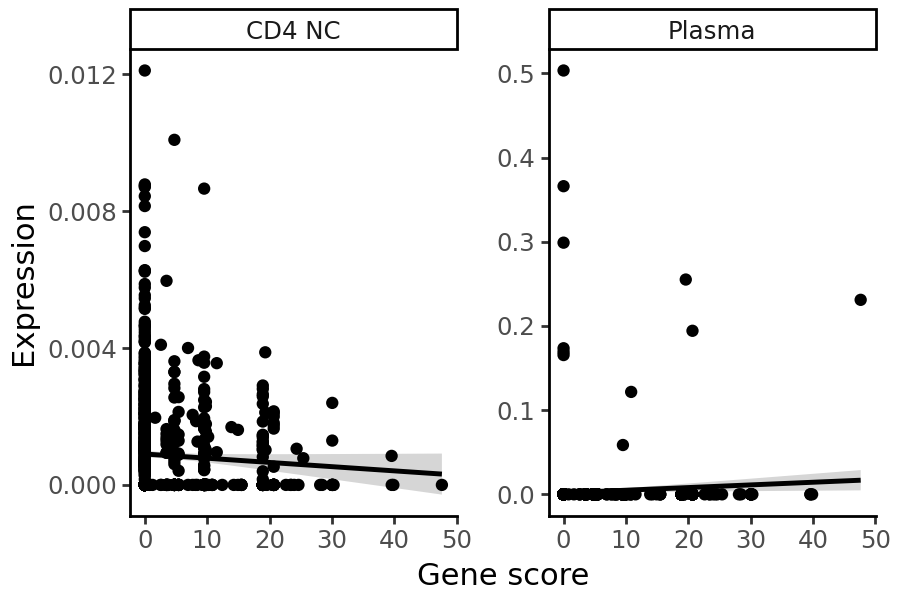

In [58]:
plot = (
    ggplot(merged, aes(x = "CADD_PHRED", y = "Expression"))
    + labs(x = "Gene score")
    + theme_classic()
    + geom_smooth()
    + geom_point()
    + facet_wrap("Cell type", scales = "free")
    + theme(legend_position="top", figure_size = (4.5,3))
)
plot